# Анализ расходов на маркетинг в Яндекс.Афиша

# Описание проекта #
Вас пригласили на стажировку в отдел маркетинговой аналитики Яндекс.Афиши. Первое задание: помочь маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет.


Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:
* лог сервера с данными о посещениях сайта Яндекс.Афиши,
* выгрузка всех заказов за этот период,
* статистика рекламных расходов.


Вам предстоит изучить:
* как клиенты пользуются сервисом,
* когда делают первые покупки на сайте,
* сколько денег приносит компании каждый клиент,
* когда расходы на привлечение клиента окупаются.


Выручка измеряется в условных единицах — у.е.

**Шаг 1. Загрузите данные и подготовьте их к анализу** 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [4]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [5]:
visits = visits.rename({'End Ts' : 'End_ts', 'Source Id' : 'Source_id', 'Start Ts' : 'Start_ts'}, axis = 1)
visits.columns = visits.columns.str.lower()
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null object
source_id    359400 non-null int64
start_ts     359400 non-null object
uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [6]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])

In [7]:
visits['source_id'].value_counts()

4     101794
3      85610
5      66905
2      47626
1      34121
9      13277
10     10025
7         36
6          6
Name: source_id, dtype: int64

In [8]:
visits.duplicated().sum()

0

In [9]:
visits['device'].value_counts()

desktop    262567
touch       96833
Name: device, dtype: int64

In [10]:
visits.duplicated().sum()

0

In [11]:
visits['date'] = visits['start_ts'].dt.date
visits['year'] = visits['start_ts'].dt.year
visits['week'] = visits['start_ts'].dt.week
visits['month'] = visits['start_ts'].dt.month
visits['day'] = visits['start_ts'].dt.day 
visits['duration'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
visits.sample(5)

,device,end_ts,source_id,start_ts,uid,date,year,week,month,day,duration
281436,desktop,2017-08-31 12:34:00,4,2017-08-31 12:33:00,16649940248631349534,2017-08-31,2017,35,8,31,60
69946,desktop,2017-07-06 12:19:00,5,2017-07-06 12:05:00,13666490430126449745,2017-07-06,2017,27,7,6,840
116908,desktop,2018-01-11 16:00:00,9,2018-01-11 16:00:00,1867384609453239560,2018-01-11,2018,2,1,11,0
260204,touch,2017-07-19 22:28:00,5,2017-07-19 22:21:00,8571004593130766909,2017-07-19,2017,29,7,19,420
216900,desktop,2018-03-26 23:41:00,3,2018-03-26 23:37:00,1306662251083005874,2018-03-26,2018,13,3,26,240


Пустных значений и дубликатов нет. Всего два типа устройств: desktop и touch (вероятно, компьютер и моб. устройства). Всего 10 источников захода на сайт (пронумерованы от 1 до 10). Привели временные параметры к соот. типы, добавили год, дату, день визита и продолжительность сессии.

In [12]:
visits['duration'].describe()

count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: duration, dtype: float64

In [13]:
# проанализируем сессии, длительностью 0 секунд
print(visits[visits['duration'] == 0]['uid'].count(), 'cессий, длительностью 0 секунд.')

35794 cессий, длительностью 0 секунд.


In [14]:
empty_visits_uid = visits[visits['duration'] == 0]['uid'].unique()
print('Всего уникальных пользователей с хотя бы одной сессией в 0 секунд', len(empty_visits_uid))

Всего уникальных пользователей с хотя бы одной сессией в 0 секунд 32812


In [15]:
empty_visits_uid_duration = visits.query('uid in @empty_visits_uid').groupby(['uid']).agg({'duration': ['mean', 'count']}).reset_index()
empty_visits_uid_duration.columns = empty_visits_uid_duration.columns.droplevel(1)
empty_visits_uid_duration.columns = ['uid', 'duration_mean', 'visits_total']
dead_uid = empty_visits_uid_duration[empty_visits_uid_duration['duration_mean'] == 0]['uid'].unique()
print('Всего уникальных пользователей, которыe ни разу не провели какое-то время на сайте', len(dead_uid))

Всего уникальных пользователей, которыe ни разу не провели какое-то время на сайте 21118


In [16]:
visits_dead_source = visits.query('uid in @dead_uid').pivot_table(index = 'source_id', columns = 'device', values = 'uid', aggfunc = 'count')
visits_dead_source

device,desktop,touch
source_id,,
1,272.0,221.0
2,831.0,565.0
3,4323.0,1750.0
4,4101.0,3041.0
5,3378.0,1730.0
7,NaN,1.0
9,350.0,159.0
10,452.0,263.0


In [17]:
visits_source = visits.pivot_table(index = 'source_id', columns = 'device', values = 'uid', aggfunc = 'count')
visits_source

device,desktop,touch
source_id,,
1,25901,8220
2,35661,11965
3,65777,19833
4,67640,34154
5,50069,16836
6,5,1
7,28,8
9,10119,3158
10,7367,2658


In [18]:
visits_dead_source_per = 100 * visits_dead_source / visits_source

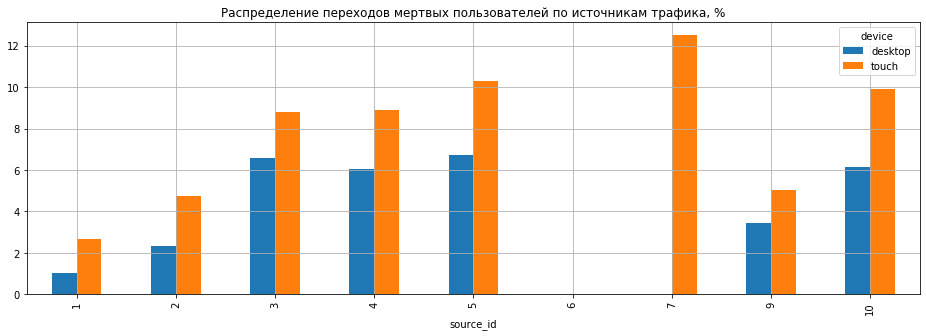

In [19]:
visits_dead_source_per.plot(kind =  'bar', grid = True, figsize = (16, 5))
plt.title('Распределение переходов мертвых пользователей по источникам трафика, %');

За год было совершено 359 400 визитов. 35 794 пользователей хотя бы раз открыли и закрыли сайт, а 21 128 пользователей делали это всегда и не провели на сайте и секунды. Такие визиты приходят со всех источников трафика (6 и 7 - мертвые источники и с них вообще нет переходов). Тем не менее больше полностью "мертвых" пользователей приходят с 3, 4 и 5 источников трафика. 

In [20]:
visits['duration'].describe()

count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: duration, dtype: float64

In [21]:
# посмотрим на данные о заказах
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [22]:
orders = orders.rename({'Buy Ts' : 'Buy_ts'}, axis = 1)
orders.columns = orders.columns.str.lower()

In [23]:
orders.sample(5)

,buy_ts,revenue,uid
10139,2017-10-02 17:33:00,3.05,17261470705637012392
27049,2017-12-29 20:43:00,3.67,905134426680760661
14358,2017-10-24 16:38:00,1.22,14499762075623552523
14701,2017-10-26 14:07:00,1.10,17556859519245406189
32891,2018-02-04 14:22:00,0.98,15282214086763188103


In [24]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
orders['buy_ts_month'] = orders['buy_ts'].dt.strftime('%Y-%m')
orders[orders['buy_ts_month'] == '2018-06']

,buy_ts,revenue,uid,buy_ts_month
50414,2018-06-01 00:02:00,3.42,83872787173869366,2018-06


In [25]:
#в данных есть дата 1.06, привяжем ей месяц май 18, так как сделалан заказ в 00:02 секунды
orders.loc[50414, 'buy_ts_month'] = '2018-05'
orders.loc[50414] 

buy_ts          2018-06-01 00:02:00
revenue                        3.42
uid               83872787173869366
buy_ts_month                2018-05
Name: 50414, dtype: object

In [26]:
# посмотрим на заказы с суммой 0 у.е.
orders[orders['revenue'] == 0]['uid'].value_counts()

2037345392173160982     12
5603453646174104178      6
8277558335454815700      6
5570343171257035973      4
4927261749585088199      4
2883839899480223178      2
13486014841579728464     1
14973814017160376581     1
13594493436687104785     1
10281425020415612933     1
1149062814762747892      1
6538135401269860305      1
10169885790465067808     1
184148767273119549       1
5342067285161169772      1
2636645662067512510      1
14872085179275033073     1
17030528792926543083     1
15254206642996645755     1
1879819502567241225      1
9971607959588724150      1
12296506984642158789     1
2936104404423239931      1
Name: uid, dtype: int64

In [27]:
print(orders[orders['revenue'] == 0]['uid'].count(), 'заказ со стоимостью 0 у.е.')

51 заказ со стоимостью 0 у.е.


In [28]:
# удалим эти заказы, так как, видимо, это попытки оплатить и транзакция срывалась.
orders = orders.drop(orders[orders.revenue == 0].index)

In [29]:
# проанализируем параментр revenue
orders['revenue'].describe()

count    50364.000000
mean         5.004710
std         21.828823
min          0.010000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

In [30]:
orders['revenue'].mode()

0    1.83
dtype: float64

In [31]:
# так как стандартное отклонение 21,8 у.е., а 75% заказорв были стоимостью менее 4,89 у.е., 
# посмотрим на заказы стоимостью более 50 у.е.(средняя + 2 стр. откл.)
print("Количество пользователей, совершавших покупки, стоимостью более 50 у.е.:", len(orders[orders['revenue'] > 50]['uid'].unique()))
print('Всего таких покупок', orders[orders['revenue'] > 50]['uid'].count())

Количество пользователей, совершавших покупки, стоимостью более 50 у.е.: 157
Всего таких покупок 308


In [32]:
print("Количество пользователей, совершавших покупки, стоимостью более 100 у.е.:", len(orders[orders['revenue'] > 100]['uid'].unique()))
print('Всего таких покупок', orders[orders['revenue'] > 100]['uid'].count())

Количество пользователей, совершавших покупки, стоимостью более 100 у.е.: 51
Всего таких покупок 113


In [33]:
print("Количество пользователей, совершавших покупки:", len(orders['uid'].unique()))
print('Всего таких покупок', orders['uid'].count())

Количество пользователей, совершавших покупки: 36509
Всего таких покупок 50364


In [34]:
strange_users = orders[orders['revenue'] > 50]['uid'].unique()
strange_orders = orders.query('uid in @strange_users')
#strange_orders
strange_orders[strange_orders['revenue'] <= 50].shape[0]

2091

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


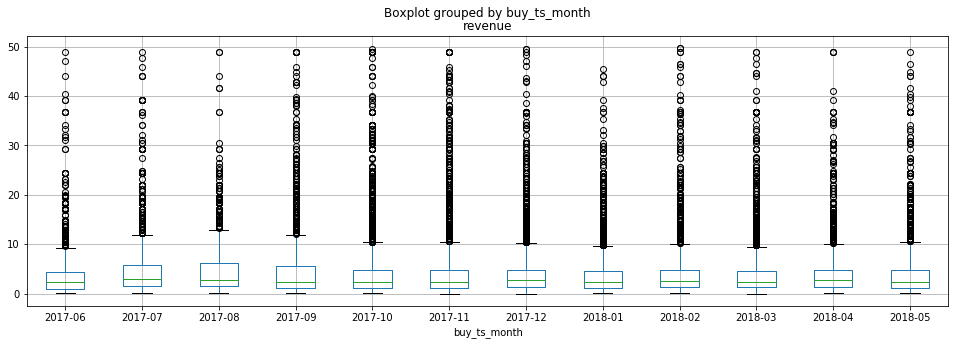

In [35]:
orders[orders.revenue < 50].boxplot('revenue', by = 'buy_ts_month', figsize = (16, 5))

В данных есть выбросы: 51 уникальных пользователей, совершивших 113 покупок, стоимостью свыше 50 у.е. Можно предположить, что был какой-то сбой валюты, но тем не менее эти пользователи совершили 2091 покупку стоимостью менее 50 у.е. Уберем данные о покупках свыше 50 у.е. из данных.

In [36]:
orders = orders.drop(orders.query('uid in @strange_users').index)

In [37]:
print('Всего было сделано заказов {} на общую сумму {} у.е.'.format(orders.shape[0], orders['revenue'].sum()))

Всего было сделано заказов 47965 на общую сумму 186855.45 у.е.


In [38]:
orders.duplicated().sum()

0

В данных есть покупки стоимость 0 y.e. Видимо, были какие-то баги с оплатой, и она не проходила, но зафиксировалась. Так же есть выбросы по стоимости заказа, вероятно, подтянулась не та валюта. Средняя по выборке 5 у.е., стандартное отклонение 21,82 у.е. Удалим данные с нулевой стоимостью заказа и более 50 у.е. 

Всего было сделано заказов 50364 на общую сумму 252057.2 у.е.

In [39]:
# проанализурем данные об оплатах на маркетинг.
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [40]:
costs.sample(5)

,source_id,dt,costs
475,2,2017-09-21,140.29
1562,5,2017-09-19,125.87
1747,5,2018-03-23,150.62
2080,9,2018-02-20,17.74
564,2,2017-12-19,166.40


In [41]:
costs.duplicated().sum()

0

In [42]:
costs['costs'].describe()

count    2542.000000
mean      129.477427
std       156.296628
min         0.540000
25%        21.945000
50%        77.295000
75%       170.065000
max      1788.280000
Name: costs, dtype: float64

In [43]:
costs = costs.rename({'dt' : 'cost_date'}, axis = 1)
costs['cost_date'] = pd.to_datetime(costs['cost_date'])

In [44]:
costs.groupby('source_id')['costs'].sum().sort_values(ascending = False)

source_id
3     141321.63
4      61073.60
5      51757.10
2      42806.04
1      20833.27
10      5822.49
9       5517.49
Name: costs, dtype: float64

На какой-то источник номер 3 потратили больше всего денег за год, а на источники - 6, 7 и 8 вообще ничего не потратили.

**Шаг 2. Расчитаем метрики.**

**Шаг 2.1 Расчитаем продуктовые метрики.**

**Шаг 2.1.1. Рассчитайте DAU, WAU и MAU. Вычислите средние значения этих метрик за весь период.**

In [45]:
#удадим полностью полностью мертвых пользователей из данных, и оценим среднее кол-во пользователей.
visits = visits.drop(visits.query('uid in @dead_uid').index)

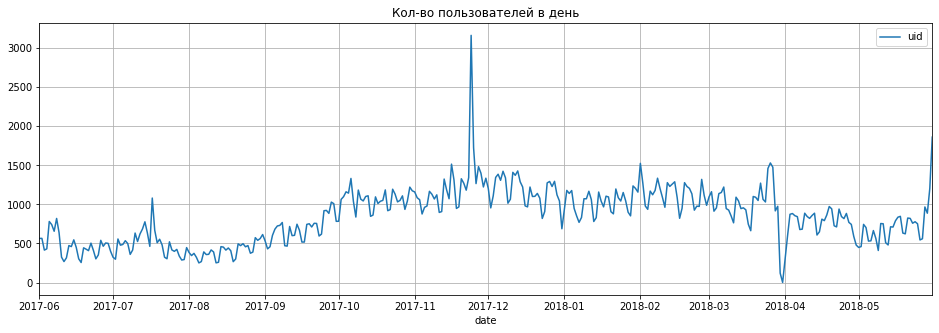

In [46]:
dau = visits.groupby(['date']).agg({'uid' : 'nunique'})
dau.plot(grid = True, figsize = (16, 5))
plt.title('Кол-во пользователей в день');

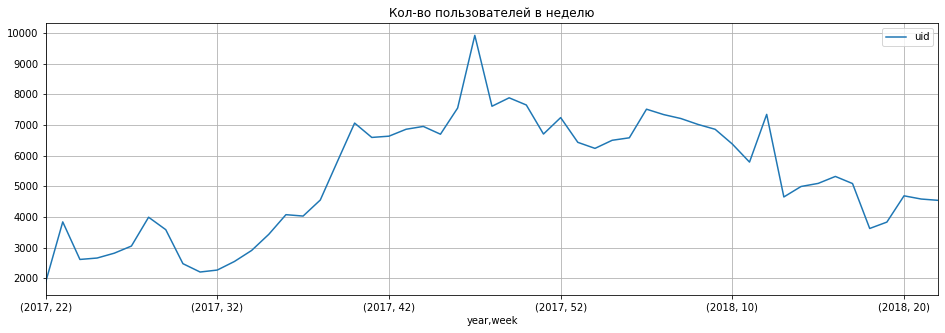

In [47]:
wau = visits.groupby(['year', 'week']).agg({'uid' : 'nunique'})
wau.plot(grid = True, figsize = (16, 5))
plt.title('Кол-во пользователей в неделю');

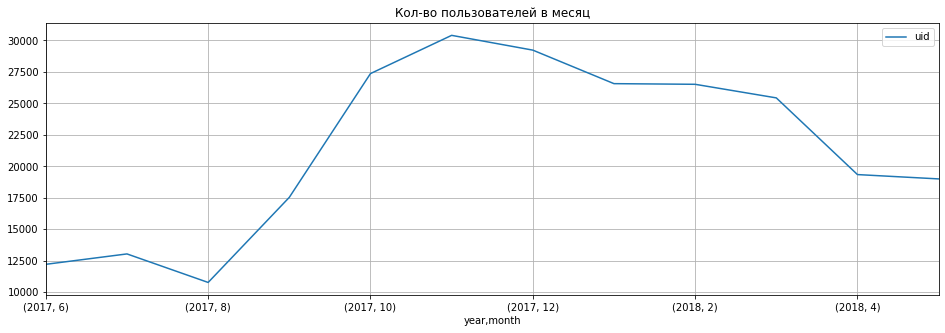

In [48]:
mau= visits.groupby(['year', 'month']).agg({'uid' : 'nunique'})
mau.plot(grid = True, figsize = (16, 5))
plt.title('Кол-во пользователей в месяц');

In [49]:
mau

uid
year month       
2017 6      12211
     7      13037
     8      10770
     9      17534
     10     27370
     11     30408
     12     29234
2018 1      26570
     2      26518
     3      25438
     4      19343
     5      18999

In [50]:
dau_mean = dau['uid'].mean()
wau_mean = wau['uid'].mean()
mau_mean = mau['uid'].mean()

print('Среднее количество активных пользователей сайта:', '\n', 'в день - {:0.2f}'.format(dau_mean), '\n', 'в неделю - {:0.2f}'.format(wau_mean), '\n', 'в год - {:0.2f}'.format(mau_mean))

Среднее количество активных пользователей сайта: 
 в день - 849.21 
 в неделю - 5313.17 
 в год - 21452.67


In [51]:
sticky_wau = dau_mean / wau_mean 
sticky_mau = dau_mean / mau_mean

print('Регулярность пользования, день/неделя: {:.2%}'.format(sticky_wau))
print('Регулярность пользования, день/месяц: {:.2%}'.format(sticky_mau))

Регулярность пользования, день/неделя: 15.98%
Регулярность пользования, день/месяц: 3.96%


**ВЫВОД:** 


В среднем Яндекс.Афиша посещает 849 пользователей в день, 5313 - в неделю, 21 452 - в месяц. Тем не менее всего лишь 16% возращаются на сайт в течение недели и 4% - в течение месяца. Пользование ресурсом носит сезонный характер: летом пользователи реже заходят на сайт, а зимой - чаще, пик наблюдается в предновогодние даты. Но можно отметить, что в целом кол-во пользователей выросло: в мае 2018 их всего было около 20,7 тыс. в месяц, когда как в июне 2017 - 13,2 тыс, а резкий рост был cентябре-октябре.

**Шаг 2.1.2. Определите, сколько раз за день пользователи в среднем заходят на сайт.**

In [52]:
visits.head()

,device,end_ts,source_id,start_ts,uid,date,year,week,month,day,duration
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017,51,12,20,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018,8,2,19,1680
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018,20,5,20,1440
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-03,2017,35,9,3,60
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,2018-01-30,2018,5,1,30,3360


In [53]:
users_per_day = visits.groupby('date').agg({'uid' : ['count', 'nunique']})
users_per_day.columns = ['n_sessions', 'n_users']
users_per_day['session_per_user'] = users_per_day['n_sessions'] / users_per_day['n_users']

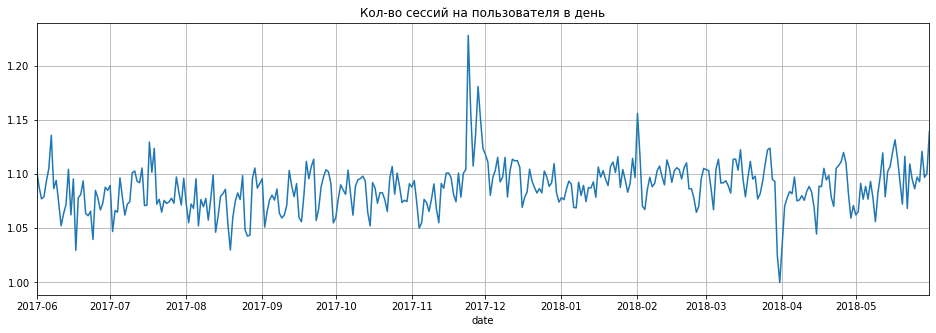

In [54]:
users_per_day['session_per_user'].plot(grid = True, figsize = (16, 5))
plt.title('Кол-во сессий на пользователя в день');

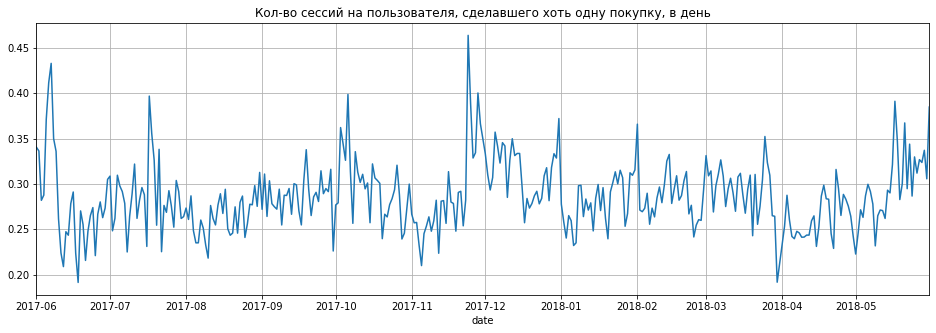

In [55]:
unique_buyers = orders['uid'].unique()

buyers_per_day = visits.query('uid in @unique_buyers').groupby('date').agg({'uid' : ['count', 'nunique']})
buyers_per_day.columns = ['n_sessions', 'n_users']
buyers_per_day['session_per_user'] = buyers_per_day['n_sessions'] / users_per_day['n_users']

buyers_per_day['session_per_user'].plot(grid = True, figsize = (16, 5))
plt.title('Кол-во сессий на пользователя, сделавшего хоть одну покупку, в день');

In [56]:
print('Пользователи в среднем заходят {:.2f} раз в день.'.format(users_per_day['session_per_user'].mean()))
print('Пользователи, совершившие хоть одну покупку, в среднем заходят {:.2f} раз в день.'.format(buyers_per_day['session_per_user'].mean()))

Пользователи в среднем заходят 1.09 раз в день.
Пользователи, совершившие хоть одну покупку, в среднем заходят 0.29 раз в день.


В среднем пользователи в течение всего времени заходят примерно 1-1.2 раза в день. Есть всплеск в конце ноября, но он не значительный - 0.1 раза. Пользователи, хоть раз сделавшие заказ, ведут себя также, но заходят в день примерно 0.31 раз. Можно сделать вывод, что реклама привлекает достаточно много "пустых" переходов.

**Шаг 2.1.3. Исследуйте, сколько времени пользователи проводят на сайте. Узнайте продолжительность типичной пользовательской сессии за весь период. Чтобы выбрать подходящую среднюю меру, постройте график распределения. Изменение продолжительности сессий во времени изучать необязательно.**

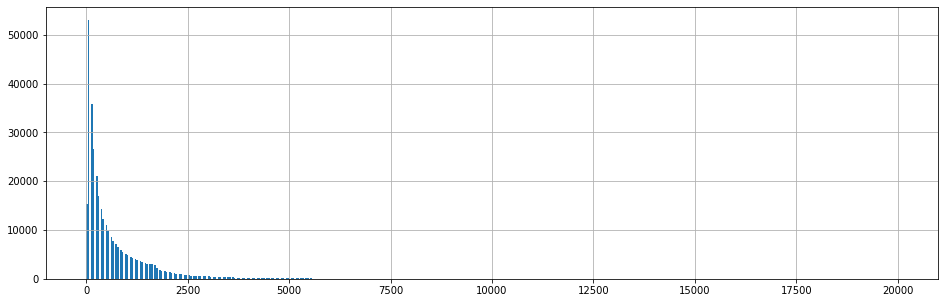

In [57]:
visits['duration'].hist(bins = 500, figsize = (16, 5), range = (0, 20000));

In [58]:
duration_mean = visits['duration'].mean()
duration_mode = visits['duration'].mode()
duration_median = visits['duration'].median()

print('Среднее значение продолжительности сессии {:.2f} секунд'.format(duration_mean))
print('Медианное значение продолжительности сессии {:.2f} секунд'.format(duration_median))
print('Модальное значение продолжительности сессии  {:.2f} секунд'.format(duration_mode.loc[0]))


Среднее значение продолжительности сессии 684.32 секунд
Медианное значение продолжительности сессии 360.00 секунд
Модальное значение продолжительности сессии  60.00 секунд


In [59]:
duration_mean_buyers = visits.query('uid in @unique_buyers')['duration'].mean()
duration_mode_buyers = visits.query('uid in @unique_buyers')['duration'].mode()
duration_median_buyers = visits.query('uid in @unique_buyers')['duration'].median()

print('Cреднее значение продолжительности сессии {:.2f} секунд'.format(duration_mean_buyers))
print('Медианное значение продолжительности сессии {:.2f} секунд'.format(duration_median_buyers))
print('Модальное значение продолжительности сессии  {:.2f} секунд'.format(duration_mode_buyers.loc[0]))


Cреднее значение продолжительности сессии 922.89 секунд
Медианное значение продолжительности сессии 480.00 секунд
Модальное значение продолжительности сессии  60.00 секунд


In [60]:
duration_mean_not_buyers = visits.query('uid not in @unique_buyers')['duration'].mean()
duration_median_not_buyers = visits.query('uid not in @unique_buyers')['duration'].median()
duration_mode_not_buyers = visits.query('uid not in @unique_buyers')['duration'].mode()

print('Среднее значение продолжительности сессии {:.2f} секунд'.format(duration_mean_not_buyers))
print('Медианное значение продолжительности сессии {:.2f} секунд'.format(duration_median_not_buyers))
print('Модальное значение продолжительности сессии  {:.2f} секунд'.format(duration_mode_not_buyers.loc[0]))

Среднее значение продолжительности сессии 596.69 секунд
Медианное значение продолжительности сессии 300.00 секунд
Модальное значение продолжительности сессии  60.00 секунд


Чаще всего пользователи проводят на севрсисе 1 минуту, а вот медиана и средняя для выборки купивших и не купших пользователей разная: 50% ни разу не купившие пользователи - 4 минуты, а купивших - 9 минут.

**Шаг 2.1.4. Рассчитайте Retention Rate, применяя когортный анализ. Найдите средний Retention Rate на второй месяц «жизни» когорт.**

In [61]:
# найдем для кажого пользователя первую дату захода на сайт, устройство и тип трафика 

first_activity = visits.groupby(['uid']).agg({'start_ts' : 'min', 'source_id' : 'first', 'device' : 'first'}).reset_index()
first_activity = first_activity.rename({'start_ts' : 'first_activity', 'source_id' : 'first_source_id', 'device' : 'first_device'}, axis = 1)

first_activity.head()

,uid,first_activity,first_source_id,first_device
0,11863502262781,2018-03-01 17:27:00,3,touch
1,49537067089222,2018-02-06 15:55:00,2,touch
2,297729379853735,2017-06-07 18:47:00,3,desktop
3,313578113262317,2017-09-18 22:49:00,2,desktop
4,325320750514679,2017-09-30 14:29:00,5,desktop


In [62]:
#добавим в таблицу visits информацию о первой дате захода, источника и девайсу.
visits = visits.merge(first_activity, on = 'uid')
visits.head()

,device,end_ts,source_id,start_ts,uid,date,year,week,month,day,duration,first_activity,first_source_id,first_device
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017,51,12,20,1080,2017-12-20 17:20:00,4,touch
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018,8,2,19,1680,2018-02-19 16:53:00,2,desktop
2,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018,20,5,20,1440,2018-03-09 20:05:00,9,desktop
3,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09,2018,10,3,9,1680,2018-03-09 20:05:00,9,desktop
4,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-03,2017,35,9,3,60,2017-09-03 21:35:00,5,desktop


In [63]:
visits['cohort_lifetime'] = visits['start_ts'] - visits['first_activity']
visits['cohort_lifetime'] = (visits['cohort_lifetime'] / np.timedelta64(1, 'M')).round().astype(int)

visits['first_visit_date'] = visits['first_activity'].dt.strftime('%Y-%m')

visits.head()

,device,end_ts,source_id,start_ts,uid,date,year,week,month,day,duration,first_activity,first_source_id,first_device,cohort_lifetime,first_visit_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017,51,12,20,1080,2017-12-20 17:20:00,4,touch,0,2017-12
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018,8,2,19,1680,2018-02-19 16:53:00,2,desktop,0,2018-02
2,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018,20,5,20,1440,2018-03-09 20:05:00,9,desktop,2,2018-03
3,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09,2018,10,3,9,1680,2018-03-09 20:05:00,9,desktop,0,2018-03
4,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-03,2017,35,9,3,60,2017-09-03 21:35:00,5,desktop,0,2017-09


In [64]:
cohorts = visits.groupby(['first_visit_date', 'cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
cohorts = cohorts.rename({'uid' : 'n_users'}, axis = 1)
cohorts.head()

,first_visit_date,cohort_lifetime,n_users
0,2017-06,0,12211
1,2017-06,1,982
2,2017-06,2,710
3,2017-06,3,812
4,2017-06,4,917


In [65]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_date','n_users']]
initial_users_count = initial_users_count.rename({'n_users':'initial_users'}, axis = 1)
initial_users_count.head()

,first_visit_date,initial_users
0,2017-06,12211
13,2017-07,11996
25,2017-08,9328
36,2017-09,15269
46,2017-10,23665


In [66]:
cohorts = cohorts.merge(initial_users_count, on = ['first_visit_date'])
cohorts.head()

,first_visit_date,cohort_lifetime,n_users,initial_users
0,2017-06,0,12211,12211
1,2017-06,1,982,12211
2,2017-06,2,710,12211
3,2017-06,3,812,12211
4,2017-06,4,917,12211


In [67]:
cohorts['retention_rate'] = cohorts['n_users'] / cohorts ['initial_users']
retention_rate_2 = cohorts[cohorts['cohort_lifetime'] == 2]['retention_rate'].mean()
cohorts.head()                                                       

,first_visit_date,cohort_lifetime,n_users,initial_users,retention_rate
0,2017-06,0,12211,12211,1.000000
1,2017-06,1,982,12211,0.080419
2,2017-06,2,710,12211,0.058144
3,2017-06,3,812,12211,0.066497
4,2017-06,4,917,12211,0.075096


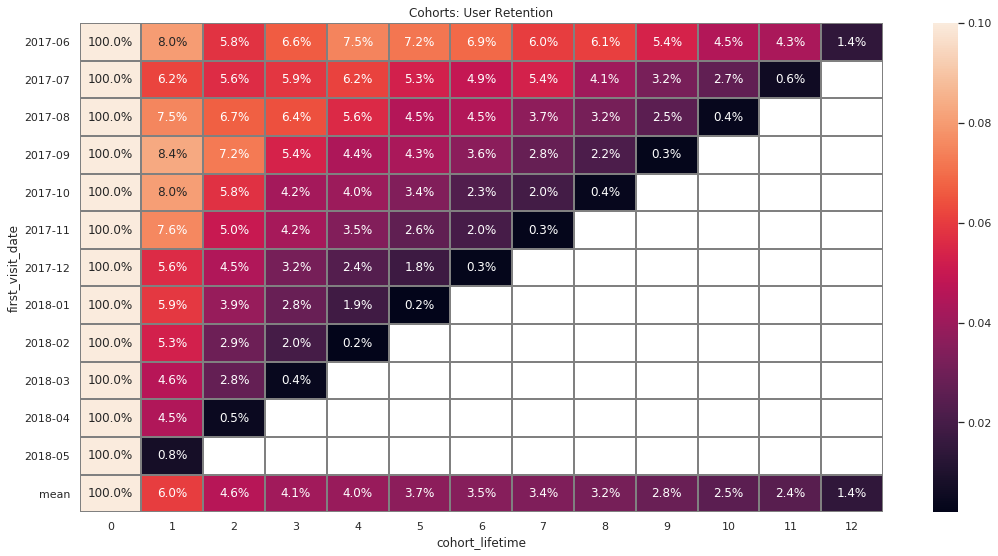

In [68]:
retention_pivot = cohorts.pivot_table(
    index='first_visit_date',
    columns='cohort_lifetime',
    values='retention_rate',
    aggfunc='sum'
) 

retention_pivot.loc['mean'] = retention_pivot.mean()

import seaborn as sns
from matplotlib import pyplot as plt
sns.set(style='white')
plt.figure(figsize=(18, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='grey', vmax = 0.10);


In [69]:
retention_rate_2 = cohorts[cohorts['cohort_lifetime'] == 2]['retention_rate'].mean()
print('Средний коэффициент удержания во второй месяц когорты {:0.2%}'.format(retention_rate_2))

Средний коэффициент удержания во второй месяц когорты 4.62%


Показатели печальные: пользователи практически не возращаются. Во второй месяц жизни когорты в среднем возращается только 4,62% пользователей. 

In [70]:
#посмотрим на активность пользователей, которые хоть раз сделали покупку

visits_buyers = visits.query('uid in @unique_buyers')

cohorts_buyers = visits_buyers.groupby(['first_visit_date', 'cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
cohorts_buyers = cohorts_buyers.rename({'uid' : 'n_users'}, axis = 1)

initial_users_count_buyers = cohorts_buyers[cohorts_buyers['cohort_lifetime'] == 0][['first_visit_date','n_users']]
initial_users_count_buyers = initial_users_count_buyers.rename({'n_users':'initial_users'}, axis = 1)

cohorts_buyers = cohorts_buyers.merge(initial_users_count_buyers, on = ['first_visit_date'])

cohorts_buyers['retention_rate'] = cohorts_buyers['n_users'] / cohorts_buyers['initial_users']
retention_rate_buyers_2 = cohorts_buyers[cohorts_buyers['cohort_lifetime'] == 2]['retention_rate'].mean()

retention_pivot_buyers = cohorts_buyers.pivot_table(
    index='first_visit_date',
    columns='cohort_lifetime',
    values='retention_rate',
    aggfunc='sum'
) 

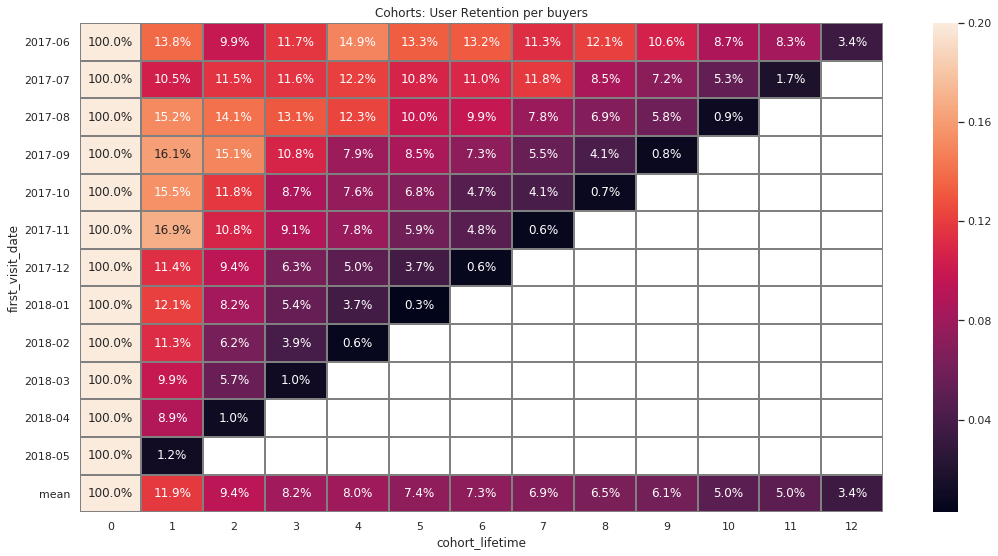

In [71]:
retention_pivot_buyers.loc['mean'] = retention_pivot_buyers.mean()

sns.set(style='white')
plt.figure(figsize=(18, 9))
plt.title('Cohorts: User Retention per buyers')
sns.heatmap(retention_pivot_buyers, annot=True, fmt='.1%', linewidths=1, linecolor='grey', vmax = 0.20);

In [72]:
print('Средний коэффициент удержания во второй месяц когорты для "купивших" пользователй {:0.2%}'.format(retention_rate_buyers_2))

Средний коэффициент удержания во второй месяц когорты для "купивших" пользователй 9.43%


**ВЫВОД** 

С среднем ресурс посещает 849 пользователей в день, 5313 - в неделю, 21 452 - в месяц. Тем не менее всего лишь 15% возращаются на сайт в течение недели и 3,96% - в течение месяца. 


Среднестатистический пользователь заходит 1 раз в день и проводит на сайте 1 минуту. 

В разбиве по когортам (пользователи впревые зашедшие на сайт в один месяц) средний коэффициент удержания во второй месяц когорты 4.62% по всем пользователям и 9,43% по пользователям, хоть раз купившим услугу. Тем не менее тендеция падающая: новые пользователи все чаще уходят.

Пользование ресурсом носит сезонный характер: летом пользователи реже заходят на сайт, а зимой - чаще, пик наблюдается в предновогодние даты, но за год среднее кол-во пользователей в месяц увеличилось.

**Шаг 2.2. Метрики электронной коммерции**

**Шаг 2.2.1. Исследуйте, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки. Изучать изменение этой метрики во времени необязательно.**

In [73]:
print('В среднем один покупатель совершает {:0.2f} покупок'.format(orders.shape[0]/len(orders['uid'].unique())))

В среднем один покупатель совершает 1.32 покупок


In [74]:
orders['revenue'].describe()

count    47965.000000
mean         3.895662
std          4.539809
min          0.010000
25%          1.220000
50%          2.440000
75%          4.890000
max         49.500000
Name: revenue, dtype: float64

In [75]:
first_order_date = orders.groupby('uid')['buy_ts'].min()
first_order_date.name = 'first_order_date'
first_order_date = first_order_date.reset_index()
first_order_date.head()

,uid,first_order_date
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2464366381792757,2018-01-28 15:54:00
3,2551852515556206,2017-11-24 10:14:00
4,3077748354309989,2018-03-03 12:33:00


In [76]:
orders_time_spend = first_order_date.merge(first_activity, on = 'uid')
orders_time_spend.head()

,uid,first_order_date,first_activity,first_source_id,first_device
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,2,desktop
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,10,touch
2,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,5,desktop
3,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,5,desktop
4,3077748354309989,2018-03-03 12:33:00,2018-03-03 12:08:00,3,touch


In [77]:
orders_time_spend['spend_time'] = orders_time_spend['first_order_date'] - orders_time_spend['first_activity']
orders_time_spend['spend_time_min'] = orders_time_spend['spend_time'].dt.seconds / 60 

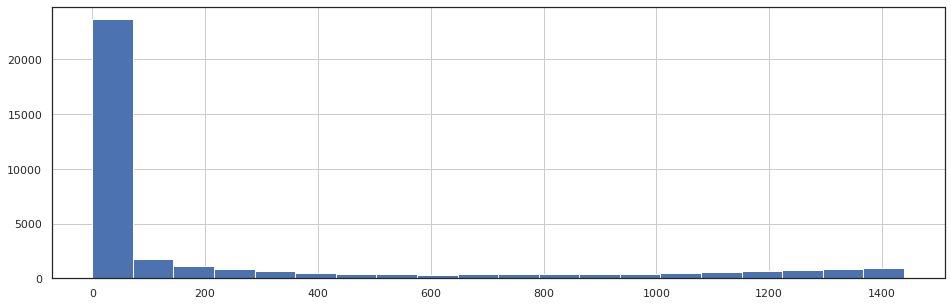

In [78]:
orders_time_spend['spend_time_min'].hist(bins = 20, figsize = (16, 5));

In [79]:
orders_time_spend['spend_time_min'].describe()

count    35911.000000
mean       246.626883
std        427.983771
min          0.000000
25%          4.000000
50%         15.000000
75%        244.500000
max       1439.000000
Name: spend_time_min, dtype: float64

In [80]:
orders_time_spend_mode = orders_time_spend['spend_time_min'].mode()

In [81]:
print('Среднее значение прошедшего времени до покупки {:.2f} часов'.format(orders_time_spend['spend_time_min'].mean()/60))
print('Медианное значение прошедшего времени до покупки {:.2f} минут'.format(orders_time_spend['spend_time_min'].median()))
print('Модальное значение прошедшего времени до покупки {:.0f} минута'.format(orders_time_spend_mode.loc[0]))


Среднее значение прошедшего времени до покупки 4.11 часов
Медианное значение прошедшего времени до покупки 15.00 минут
Модальное значение прошедшего времени до покупки 1 минута


Можно сделать вывод, что пользователи тратят время на анализ: 50% процентов пользователей проводят на сайте 15 минут, прежде чем купить услугу. 

**Шаг 2.2.2. Применяя когортный анализ или другой метод, рассчитайте среднее количество покупок на одного покупателя за определённый период, например за 6 месяцев. Изучать изменение этой метрики во времени необязательно.**

In [82]:
orders.head()

,buy_ts,revenue,uid,buy_ts_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06


In [83]:
first_activity.head()

,uid,first_activity,first_source_id,first_device
0,11863502262781,2018-03-01 17:27:00,3,touch
1,49537067089222,2018-02-06 15:55:00,2,touch
2,297729379853735,2017-06-07 18:47:00,3,desktop
3,313578113262317,2017-09-18 22:49:00,2,desktop
4,325320750514679,2017-09-30 14:29:00,5,desktop


In [84]:
# когорта - пользователи, которые сделали покупку в один месяц.
# добавим каждому пользователю дату первого визита, источник и ресурс перехода. 

orders = orders.merge(first_activity, on = 'uid')
orders.sample(10)

,buy_ts,revenue,uid,buy_ts_month,first_activity,first_source_id,first_device
44784,2018-05-07 23:32:00,1.22,15762606680302012955,2018-05,2018-05-07 23:30:00,3,desktop
27650,2017-12-26 14:25:00,2.44,2575860389337529593,2017-12,2017-12-13 08:58:00,4,desktop
21814,2017-11-27 18:58:00,0.49,17091320892877304681,2017-11,2017-11-25 20:11:00,3,touch
13114,2017-10-07 12:24:00,0.61,841010360825308755,2017-10,2017-10-07 12:19:00,10,desktop
253,2017-06-02 11:03:00,2.20,11703978165784724501,2017-06,2017-06-02 10:36:00,2,desktop
6270,2017-10-10 10:54:00,3.54,16815024995895977665,2017-10,2017-08-05 11:33:00,9,desktop
18213,2017-11-07 21:19:00,1.83,11935970100276512152,2017-11,2017-11-07 21:17:00,2,desktop
27017,2017-12-22 20:59:00,1.47,12792893281389033770,2017-12,2017-10-15 23:24:00,1,desktop
3340,2017-06-30 22:26:00,1.53,9885362225553427709,2017-06,2017-06-30 11:11:00,2,desktop
21203,2017-11-24 20:11:00,0.30,15232262789059957531,2017-11,2017-11-24 17:49:00,4,desktop


In [85]:
first_order = orders.groupby('uid').agg({'buy_ts' : 'first'})
orders = orders.merge(first_order_date, on = 'uid')
orders.head()

,buy_ts,revenue,uid,buy_ts_month,first_activity,first_source_id,first_device,first_order_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06,2017-06-01 00:09:00,1,desktop,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06,2017-06-01 00:14:00,2,desktop,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06,2017-06-01 00:25:00,2,desktop,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06,2017-06-01 00:14:00,2,desktop,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06,2017-06-01 07:31:00,3,desktop,2017-06-01 07:58:00


In [86]:
# посчитаем, сколько прошло времени с даты первого захода до покупки.
orders['cohort_lifetime'] = orders['buy_ts'] - orders['first_order_date']

In [87]:
orders['cohort_lifetime'] = orders['cohort_lifetime'] / np.timedelta64(1, 'M')
orders.head()

,buy_ts,revenue,uid,buy_ts_month,first_activity,first_source_id,first_device,first_order_date,cohort_lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06,2017-06-01 00:09:00,1,desktop,2017-06-01 00:10:00,0.0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06,2017-06-01 00:14:00,2,desktop,2017-06-01 00:25:00,0.0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06,2017-06-01 00:25:00,2,desktop,2017-06-01 00:27:00,0.0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06,2017-06-01 00:14:00,2,desktop,2017-06-01 00:29:00,0.0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06,2017-06-01 07:31:00,3,desktop,2017-06-01 07:58:00,0.0


In [88]:
orders['cohort_lifetime'] = orders['cohort_lifetime'].round().astype(int)
orders['first_visit_date'] = orders['first_activity'].dt.strftime('%Y-%m')
orders['first_order_date'] = orders['first_order_date'].dt.strftime('%Y-%m')

In [89]:
cohorts_orders = orders.groupby(['first_order_date', 'cohort_lifetime']).agg({'uid' : 'count', 'revenue':'sum'}).reset_index()
#cohorts_orders.columns = cohorts_orders.columns.droplevel(1)
#cohorts_orders.columns = ['first_visit_date', 'cohort_lifetime', 'total_orders', 'total_revenue']

cohorts_orders = cohorts_orders.rename({'uid' : 'total_orders', 'revenue' : 'total_revenue'}, axis = 1)
cohorts_orders.head()

,first_order_date,cohort_lifetime,total_orders,total_revenue
0,2017-06,0,2277,8115.08
1,2017-06,1,72,373.69
2,2017-06,2,73,406.60
3,2017-06,3,146,812.30
4,2017-06,4,180,842.37


In [90]:
unique_buyers = orders.groupby('first_order_date').agg({'uid':'nunique'}).reset_index()
unique_buyers = unique_buyers.rename({'uid':'unique_buyers'}, axis = 1)
#unique_buyers['unique_buyer'].sum()
unique_buyers

,first_order_date,unique_buyers
0,2017-06,1983
1,2017-07,1889
2,2017-08,1352
3,2017-09,2525
4,2017-10,4267
5,2017-11,4026
6,2017-12,4316
7,2018-01,3324
8,2018-02,3604
9,2018-03,3464


In [91]:
#добавим количество уникальных покупателей
#cohorts_orders = cohorts_orders.merge(initial_users_count, on = 'first_visit_date')
cohorts_orders = cohorts_orders.merge(unique_buyers, on = 'first_order_date')
cohorts_orders.head()

,first_order_date,cohort_lifetime,total_orders,total_revenue,unique_buyers
0,2017-06,0,2277,8115.08,1983
1,2017-06,1,72,373.69,1983
2,2017-06,2,73,406.60,1983
3,2017-06,3,146,812.30,1983
4,2017-06,4,180,842.37,1983


In [92]:
#cohorts_orders['order_per_user'] = (cohorts_orders['total_orders'] / cohorts_orders['initial_users'])
cohorts_orders['order_per_buyer'] = (cohorts_orders['total_orders'] / cohorts_orders['unique_buyers'])

In [93]:
#cohorts_orders_pivot_users = cohorts_orders.pivot_table(index = 'first_visit_date', columns = 'cohort_lifetime', values = 'order_per_user', aggfunc = 'sum')
cohorts_orders_pivot_buyers = cohorts_orders.pivot_table(index = 'first_order_date', columns = 'cohort_lifetime', values = 'order_per_buyer', aggfunc = 'sum')


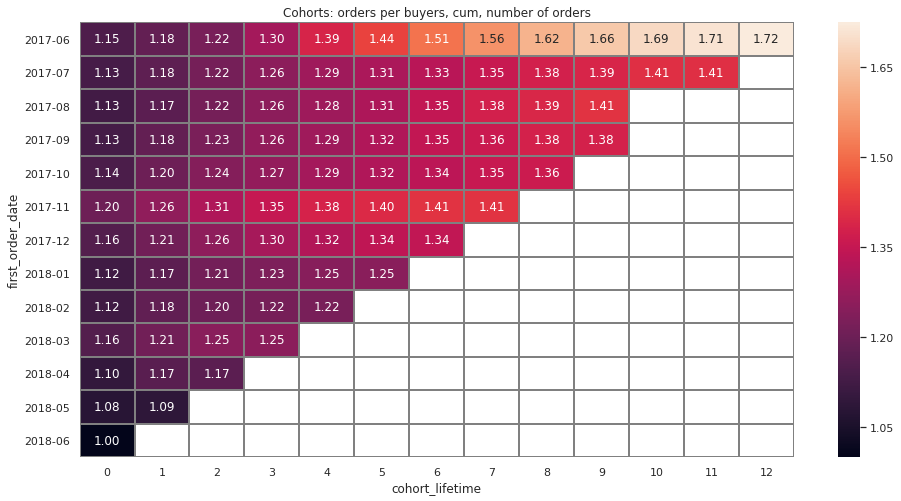

In [94]:
cohorts_orders_pivot_buyers_cum = cohorts_orders_pivot_buyers.cumsum(axis=1)

sns.set(style='white')
plt.figure(figsize=(16, 8))
plt.title('Cohorts: orders per buyers, cum, number of orders')
sns.heatmap(cohorts_orders_pivot_buyers_cum, annot=True, fmt='.2f', linewidths=1, linecolor='gray');

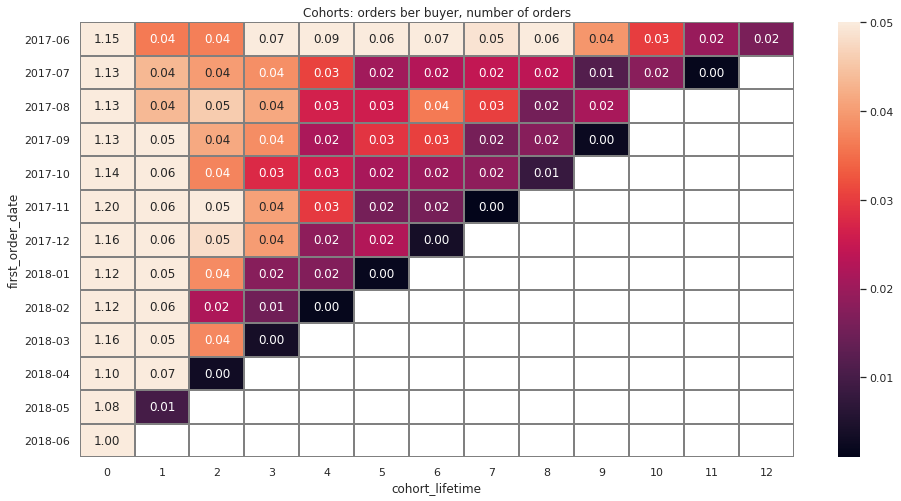

In [95]:
sns.set(style='white')
plt.figure(figsize=(16, 8))
plt.title('Cohorts: orders ber buyer, number of orders')
sns.heatmap(cohorts_orders_pivot_buyers, annot=True, fmt='.2f', linewidths=1, linecolor='gray', vmax = 0.05);

In [96]:
#print('В среднем один пользователь делает {:.2f} покупок за 6 месяцев пользования ресурсом'.format(cohorts_orders_pivot_users_cum.mean(axis = 0)[5]))
print('В среднем один покупатель делает {:.2f} покупок за 6 месяцев пользования ресурсом.'.format(cohorts_orders_pivot_buyers_cum.mean(axis = 0)[5]))

В среднем один покупатель делает 1.33 покупок за 6 месяцев пользования ресурсом.


**Шаг 2.2.3. Рассчитайте средний чек, применяя группировку по времени совершения покупки. Когортный анализ не подходит — он может исказить расчёты. Постройте график, отражающий изменения метрики во времени.**

In [97]:
orders['buy_ts_date'] = orders['buy_ts'].dt.date
orders.head()

,buy_ts,revenue,uid,buy_ts_month,first_activity,first_source_id,first_device,first_order_date,cohort_lifetime,first_visit_date,buy_ts_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06,2017-06-01 00:09:00,1,desktop,2017-06,0,2017-06,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06,2017-06-01 00:14:00,2,desktop,2017-06,0,2017-06,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06,2017-06-01 00:25:00,2,desktop,2017-06,0,2017-06,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06,2017-06-01 00:14:00,2,desktop,2017-06,0,2017-06,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06,2017-06-01 07:31:00,3,desktop,2017-06,0,2017-06,2017-06-01


In [98]:
orders['revenue'].describe()

count    47492.000000
mean         3.896295
std          4.543552
min          0.010000
25%          1.220000
50%          2.440000
75%          4.890000
max         49.500000
Name: revenue, dtype: float64

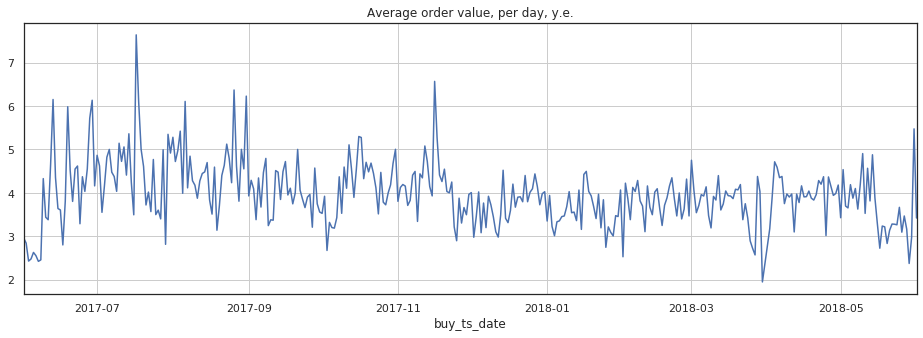

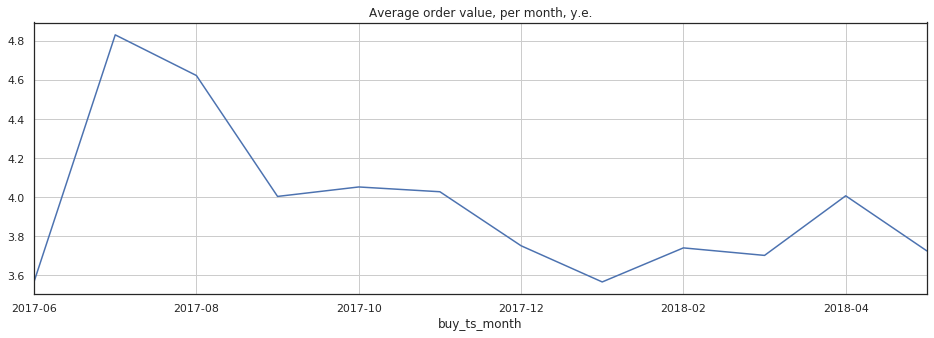

In [99]:
aov_day = orders.groupby('buy_ts_date')['revenue'].mean()
aov_month = orders.groupby('buy_ts_month')['revenue'].mean()

plt.figure(figsize=(16, 5))
plt.title('Average order value, per day, y.e.')
aov_day.plot(grid = True);

plt.figure(figsize=(16, 5))
plt.title('Average order value, per month, y.e.')
aov_month.plot(grid = True);

In [100]:
aov_month

buy_ts_month
2017-06    3.568737
2017-07    4.829251
2017-08    4.621493
2017-09    4.003911
2017-10    4.052238
2017-11    4.027845
2017-12    3.751973
2018-01    3.567075
2018-02    3.741038
2018-03    3.702657
2018-04    4.007096
2018-05    3.725611
Name: revenue, dtype: float64

In [101]:
print('Средний чек за весь период {:.2f}'.format(orders['revenue'].mean()))

Средний чек за весь период 3.90


Средний чек в июле 2017 достиг самого высокого значения, а далее начал падать и к июню 2018 достиг отметки в 3,7 у.е. Средний чек за весь приод - 3.9 у.е.

**Шаг 2.2.4. Выясните, как меняется во времени LTV на покупателя по когортам. Помните, что LTV — накопительная метрика. Рассчитайте средний LTV по когортам за 6 месяцев; в расчёт включайте когорты, «прожившие» не менее 6 месяцев. Маржинальность сервиса — 100%.**

In [102]:
cohorts_orders.head()

,first_order_date,cohort_lifetime,total_orders,total_revenue,unique_buyers,order_per_buyer
0,2017-06,0,2277,8115.08,1983,1.148260
1,2017-06,1,72,373.69,1983,0.036309
2,2017-06,2,73,406.60,1983,0.036813
3,2017-06,3,146,812.30,1983,0.073626
4,2017-06,4,180,842.37,1983,0.090772


In [103]:
cohorts_orders['ltv'] = cohorts_orders['total_revenue'] / cohorts_orders['unique_buyers']
cohorts_orders.head()

,first_order_date,cohort_lifetime,total_orders,total_revenue,unique_buyers,order_per_buyer,ltv
0,2017-06,0,2277,8115.08,1983,1.148260,4.092325
1,2017-06,1,72,373.69,1983,0.036309,0.188447
2,2017-06,2,73,406.60,1983,0.036813,0.205043
3,2017-06,3,146,812.30,1983,0.073626,0.409632
4,2017-06,4,180,842.37,1983,0.090772,0.424796


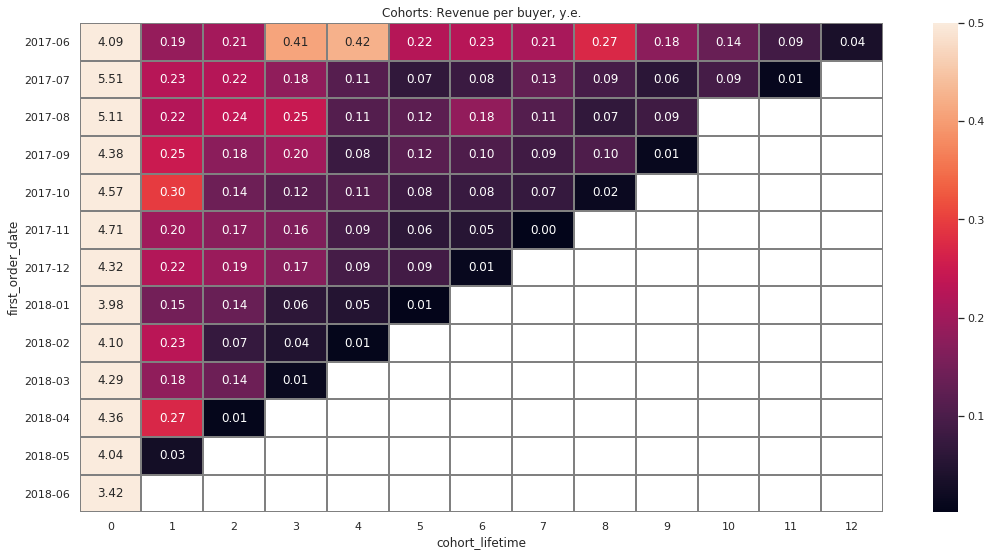

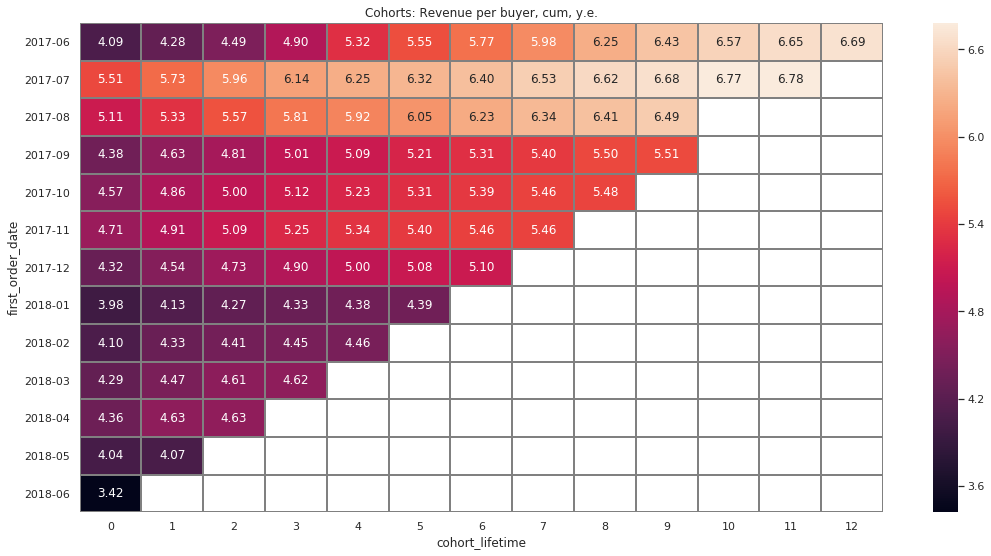

In [104]:
cohorts_revenue_pivot = cohorts_orders.pivot_table(index = 'first_order_date', columns = 'cohort_lifetime', values = 'ltv', aggfunc = 'sum')
cohorts_revenue_pivot_cum = cohorts_revenue_pivot.cumsum(axis = 1) 

sns.set(style='white')
plt.figure(figsize=(18, 9))
plt.title('Cohorts: Revenue per buyer, y.e.')
sns.heatmap(cohorts_revenue_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='grey', vmax = 0.5);

sns.set(style='white')
plt.figure(figsize=(18, 9))
plt.title('Cohorts: Revenue per buyer, cum, y.e.')
sns.heatmap(cohorts_revenue_pivot_cum, annot=True, fmt='.2f', linewidths=1, linecolor='grey');


In [105]:
cohorts_live = cohorts_revenue_pivot_cum[cohorts_revenue_pivot_cum[5] > 0].index.tolist()
cohorts_revenue_pivot_cum_live = cohorts_revenue_pivot_cum.loc[cohorts_revenue_pivot_cum.index.isin(cohorts_live)].loc[:, 0 : 5]

In [106]:
# расчитаем LVT для всех когорт за весь период времени
ltv_cohorts = cohorts_revenue_pivot_cum.mean(axis=1).mean(axis = 0)
print('В среднем каждый пользователь приносит {:.2f} у.е. валовый прибыли'.format(ltv_cohorts))

В среднем каждый пользователь приносит 4.86 у.е. валовый прибыли


In [107]:
# расчитаем LVT за 6 месяцев для когорт, которые проижили не менее 6 месяцев
lvt_6mon = cohorts_revenue_pivot_cum_live.mean(axis=1).mean(axis = 0)
print('В среднем пользователь приносит {:.2f} у.е. валовый прибыли за 6 месяцев пользования сервисом'.format(lvt_6mon))

В среднем пользователь приносит 5.05 у.е. валовый прибыли за 6 месяцев пользования сервисом


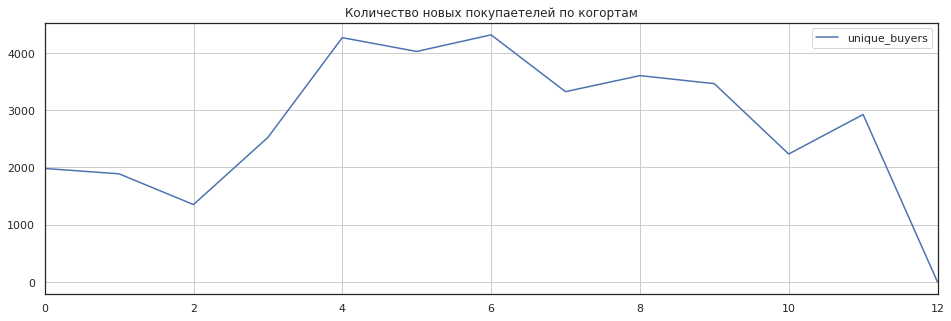

In [108]:
unique_buyers.plot(figsize=(16, 5), grid = True)
plt.title('Количество новых покупаетелей по когортам');

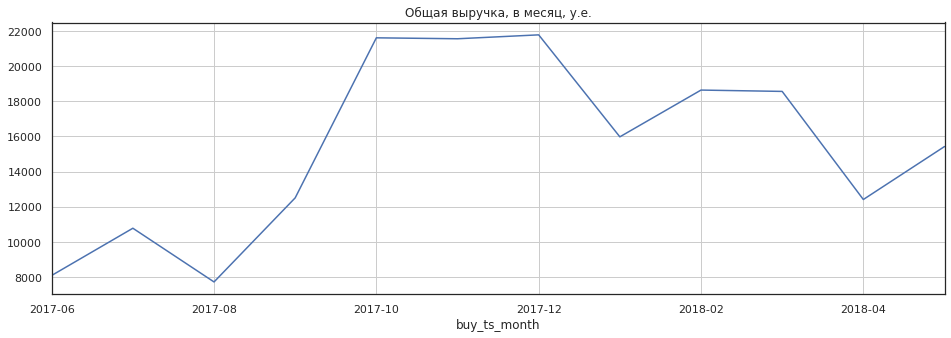

In [109]:
orders.groupby('buy_ts_month')['revenue'].sum().plot(figsize=(16, 5), grid = True)
plt.title('Общая выручка, в месяц, y.e.');

**ВЫВОД**

В среднем пользователь проводит около 15 минут на сайте с захода на сайт до совершения первой покупки. За 6 месяцов пользования ресурсом покупатель делает 1,33 покупок и приносит 5.05 у.е. валовый прибыли.

Средний чек падает достигает своего пика в июле 2017 года, и далее падает до примерно 4 у.е. Криническое значение в 3,7 у.е. наблюдается в январе 2018 года, но это "мертвый" месяц. За весь период средний чек составляет 3,9 у.е.

В целом падающий. Новых покупателей становится все меньше, в нулевой месяц они делаю все меньше покупок: от 1,15 в июне 2011 до 1.0 покупок на человека. Время жизни когорт уменьшаются: покупатели не делают повторных покупок. Соответвенно себя ведет и LVT: падает средняя прибыль в нулевой месяц, а за счет отсутсвия повторных покупок накопленная прибыль не увеличивается, общая прибыль в месяц падает не так быстро за счет покупок "страрых" когорт.  

Также можно отметить когорты в июле и ноябре: они показывают самую высокую динамику по количеству покупок, а покупатели в июльской когорте - самую высокую динамику по вырученной прибыль с клиента.


**Шаг 2.3. Маркетинговые метрики**

**Шаг 2.3.1. Посчитайте общую сумму расходов на маркетинг. Выясните, как траты распределены по источникам.**

In [110]:
costs['date'] = costs['cost_date'].dt.strftime('%Y-%m')
#costs['date']= costs['date'].dt.strftime('%Y-%m')
costs.head()

,source_id,cost_date,costs,date
0,1,2017-06-01,75.20,2017-06
1,1,2017-06-02,62.25,2017-06
2,1,2017-06-03,36.53,2017-06
3,1,2017-06-04,55.00,2017-06
4,1,2017-06-05,57.08,2017-06


In [111]:
costs.describe()

,source_id,costs
count,2542.000000,2542.000000
mean,4.857199,129.477427
std,3.181581,156.296628
min,1.000000,0.540000
25%,2.000000,21.945000
50%,4.000000,77.295000
75%,9.000000,170.065000
max,10.000000,1788.280000


In [112]:
source_costs = costs.groupby('source_id')['costs'].sum().reset_index()
total_costs = source_costs['costs'].sum()
print('Общая сумма расходов за весь период составляет {:.2f} y.e.'.format(total_costs))

Общая сумма расходов за весь период составляет 329131.62 y.e.


In [113]:
source_costs = costs.groupby('source_id')['costs'].sum().reset_index()
total_costs = source_costs['costs'].sum()
source_costs['costs_%'] = (100 * source_costs['costs'] / total_costs)
source_costs

,source_id,costs,costs_%
0,1,20833.27,6.329769
1,2,42806.04,13.005751
2,3,141321.63,42.937725
3,4,61073.60,18.555981
4,5,51757.10,15.725350
5,9,5517.49,1.676378
6,10,5822.49,1.769046


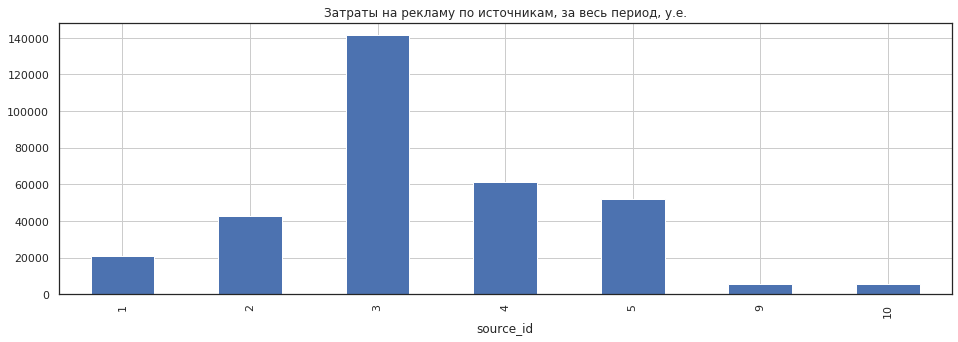

In [114]:
source_costs.set_index('source_id', inplace=True)
source_costs['costs'].plot(kind = 'bar', grid = True, figsize = (16, 5))
plt.title('Затраты на рекламу по источникам, за весь период, у.е.');

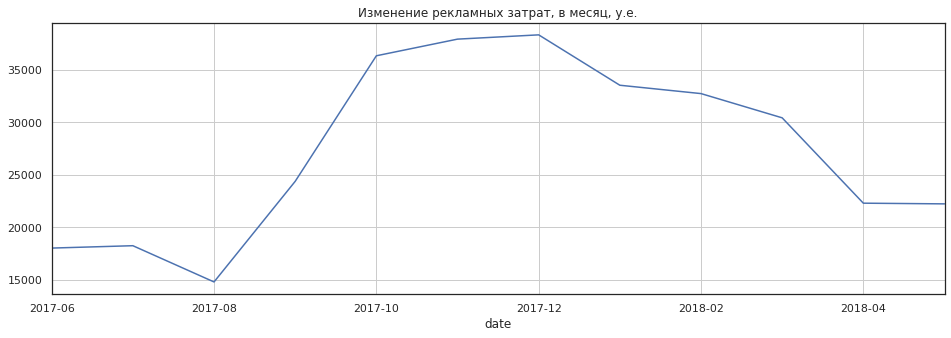

In [115]:
costs.groupby('date')['costs'].sum().plot(grid = True, figsize = (16, 5))
plt.title('Изменение рекламных затрат, в месяц, у.е.');

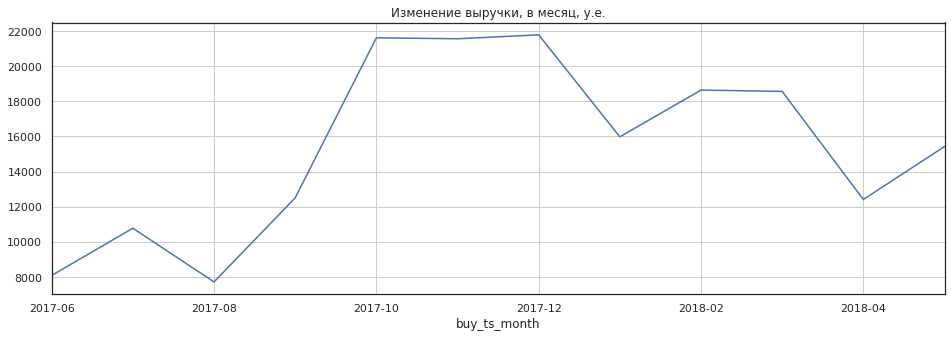

In [116]:
orders.groupby('buy_ts_month')['revenue'].sum().plot(grid = True, figsize = (16, 5))
plt.title('Изменение выручки, в месяц, у.е.');

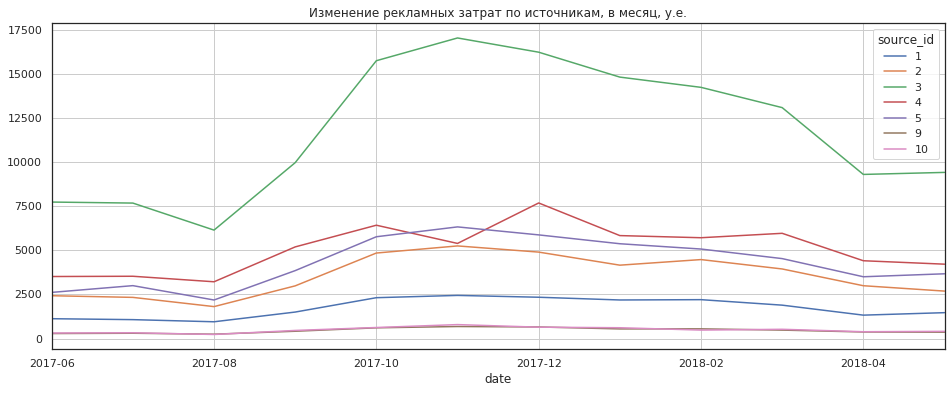

In [117]:
source_costs_pivot = costs.pivot_table(index = 'date', columns = 'source_id', values = 'costs', aggfunc = 'sum')
source_costs_pivot.plot(grid = True, figsize = (16, 6))
plt.title('Изменение рекламных затрат по источникам, в месяц, у.е.');

Больше всего потратили на рекламу на 3 ресурсе, на 1, 9 и 10 ресурсы практически на тратятся.

**Шаг 2.3.2. Рассчитайте средний CAC на одного покупателя для всего проекта и для каждого источника трафика.**

In [118]:
cac_total = total_costs / len(orders['uid'].unique())
print('Стоимоcть привлечения одного пользователя составляет {:.2f} y.e. за весь период'.format(cac_total))

Стоимоcть привлечения одного пользователя составляет 9.17 y.e. за весь период


In [119]:
orders.head()

,buy_ts,revenue,uid,buy_ts_month,first_activity,first_source_id,first_device,first_order_date,cohort_lifetime,first_visit_date,buy_ts_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06,2017-06-01 00:09:00,1,desktop,2017-06,0,2017-06,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06,2017-06-01 00:14:00,2,desktop,2017-06,0,2017-06,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06,2017-06-01 00:25:00,2,desktop,2017-06,0,2017-06,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06,2017-06-01 00:14:00,2,desktop,2017-06,0,2017-06,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06,2017-06-01 07:31:00,3,desktop,2017-06,0,2017-06,2017-06-01


In [120]:
#посчитаем уникальное кол-во покупателей в разрезе месяца с группировкой по первому источнику прихода 
initial_buyers_source = orders.groupby(['first_source_id', 'first_order_date']).agg({'uid':'nunique'}).reset_index()
initial_buyers_source = initial_buyers_source.rename({'first_source_id' : 'source_id', 'uid' : 'initial_buyers'}, axis = 1)
initial_buyers_source.groupby('source_id')['initial_buyers'].sum()

source_id
1     3675
2     4239
3     8994
4     9650
5     6728
7        1
9     1404
10    1220
Name: initial_buyers, dtype: int64

In [121]:
costs.groupby('source_id')['costs'].sum()

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

In [122]:
#посчитаем сумму затрат на каждый источник в разрезе месяца
source_costs_month = costs.groupby(['source_id', 'date']).agg({'costs':'sum'}).reset_index()
source_costs_month.head()

,source_id,date,costs
0,1,2017-06,1125.61
1,1,2017-07,1072.88
2,1,2017-08,951.81
3,1,2017-09,1502.01
4,1,2017-10,2315.75


In [123]:
#сформируем итоговую таблицу: источник трафика, месяц, затраты на источник трафика, кол-во привлеченных пользователей
report = pd.merge(source_costs_month, initial_buyers_source, left_on = ['source_id', 'date'], right_on=['source_id', 'first_order_date'], how = 'outer')
report = report.drop('first_order_date', axis = 1)
report['cac'] = report['costs'] / report['initial_buyers']
report.head()

,source_id,date,costs,initial_buyers,cac
0,1,2017-06,1125.61,195,5.772359
1,1,2017-07,1072.88,203,5.285123
2,1,2017-08,951.81,143,6.656014
3,1,2017-09,1502.01,274,5.481788
4,1,2017-10,2315.75,402,5.760572


In [124]:
cac = report.groupby(by = 'source_id').agg({'costs' : 'sum', 'initial_buyers' : 'sum', 'cac' : 'mean'}).reset_index()
cac

,source_id,costs,initial_buyers,cac
0,1,20833.27,3675,5.712332
1,2,42806.04,4239,10.289855
2,3,141321.63,8994,16.116759
3,4,61073.60,9650,6.809058
4,5,51757.10,6728,7.680353
5,7,0.00,1,NaN
6,9,5517.49,1404,4.337605
7,10,5822.49,1220,5.322619


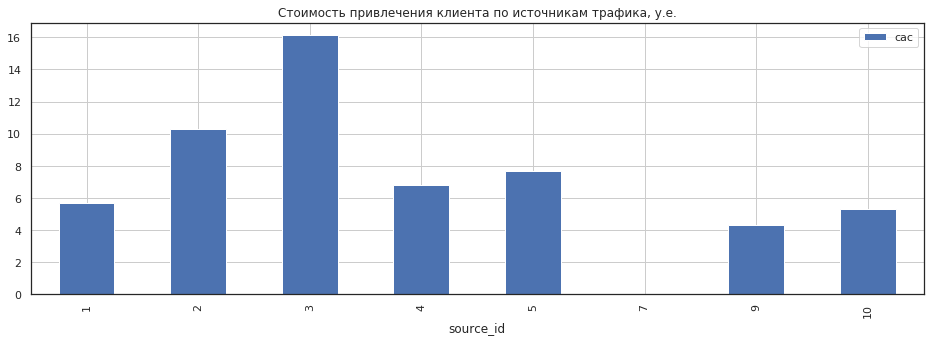

In [125]:
cac.loc[:, ['source_id', 'cac']].set_index('source_id').plot(kind = 'bar',  grid = True, figsize = (16, 5))
plt.title('Стоимость привлечения клиента по источникам трафика, у.е.');

Средняя стоимость привлечени клиента - 9.17 у.е. по всем источникам, при этом самый дорогие источники - 2 и 3 с САС 10.46 и 15.96 у.е. соотвественно. 

**Шаг 2.3.3. Рассчитайте ROMI по когортам в разрезе источников. Сравните окупаемость за одинаковые периоды жизни когорт. Обратите внимание, что клиенты, пришедшие из разных источников, могут иметь разный LTV. Постройте графики, отражающие изменения метрик во времени.** 

In [126]:
source = visits.groupby(['source_id']).agg({'uid':'count'}).reset_index()
source = source.rename({'uid' : 'number_sessions'}, axis = 1)
source['%_sessions'] = 100 * source['number_sessions'] / visits.shape[0]

source

,source_id,number_sessions,%_sessions
0,1,33628,9.950202
1,2,46230,13.679012
2,3,79537,23.534233
3,4,94652,28.006616
4,5,61797,18.285138
5,6,6,0.001775
6,7,35,0.010356
7,9,12768,3.777928
8,10,9310,2.754739


Больше всего заходов было совершено чем источники 2 и 3 (23,8 и 28,3% соответсвенно из всех заходов на страницу сервиса). 

In [127]:
report.head()

,source_id,date,costs,initial_buyers,cac
0,1,2017-06,1125.61,195,5.772359
1,1,2017-07,1072.88,203,5.285123
2,1,2017-08,951.81,143,6.656014
3,1,2017-09,1502.01,274,5.481788
4,1,2017-10,2315.75,402,5.760572


In [128]:
orders.head()

,buy_ts,revenue,uid,buy_ts_month,first_activity,first_source_id,first_device,first_order_date,cohort_lifetime,first_visit_date,buy_ts_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06,2017-06-01 00:09:00,1,desktop,2017-06,0,2017-06,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06,2017-06-01 00:14:00,2,desktop,2017-06,0,2017-06,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06,2017-06-01 00:25:00,2,desktop,2017-06,0,2017-06,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06,2017-06-01 00:14:00,2,desktop,2017-06,0,2017-06,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06,2017-06-01 07:31:00,3,desktop,2017-06,0,2017-06,2017-06-01


In [129]:
cohort_source = orders.groupby(['first_order_date', 'cohort_lifetime', 'first_source_id'])['revenue'].sum().reset_index()
cohort_source.head()

,first_order_date,cohort_lifetime,first_source_id,revenue
0,2017-06,0,1,1049.54
1,2017-06,0,2,1017.56
2,2017-06,0,3,1927.00
3,2017-06,0,4,1846.79
4,2017-06,0,5,1730.94


In [130]:
cohort_source = pd.merge(cohort_source, report, left_on = ['first_order_date', 'first_source_id'], right_on = ['date', 'source_id'])
cohort_source.head()

,first_order_date,cohort_lifetime,first_source_id,revenue,source_id,date,costs,initial_buyers,cac
0,2017-06,0,1,1049.54,1,2017-06,1125.61,195,5.772359
1,2017-06,1,1,66.39,1,2017-06,1125.61,195,5.772359
2,2017-06,2,1,79.64,1,2017-06,1125.61,195,5.772359
3,2017-06,3,1,337.19,1,2017-06,1125.61,195,5.772359
4,2017-06,4,1,354.40,1,2017-06,1125.61,195,5.772359


In [131]:
cohort_source['ltv'] = cohort_source['revenue'] / cohort_source['initial_buyers']

In [132]:
cohort_source['ltv_cum'] = cohort_source.groupby(['first_order_date', 'first_source_id'])['ltv'].cumsum()
cohort_source['romi'] = cohort_source ['ltv_cum'] / cohort_source['cac'] 
cohort_source.head(10)

,first_order_date,cohort_lifetime,first_source_id,revenue,source_id,date,costs,initial_buyers,cac,ltv,ltv_cum,romi
0,2017-06,0,1,1049.54,1,2017-06,1125.61,195,5.772359,5.382256,5.382256,0.932419
1,2017-06,1,1,66.39,1,2017-06,1125.61,195,5.772359,0.340462,5.722718,0.991400
2,2017-06,2,1,79.64,1,2017-06,1125.61,195,5.772359,0.408410,6.131128,1.062153
3,2017-06,3,1,337.19,1,2017-06,1125.61,195,5.772359,1.729179,7.860308,1.361715
4,2017-06,4,1,354.40,1,2017-06,1125.61,195,5.772359,1.817436,9.677744,1.676566
5,2017-06,5,1,209.95,1,2017-06,1125.61,195,5.772359,1.076667,10.754410,1.863088
6,2017-06,6,1,303.76,1,2017-06,1125.61,195,5.772359,1.557744,12.312154,2.132950
7,2017-06,7,1,272.85,1,2017-06,1125.61,195,5.772359,1.399231,13.711385,2.375352
8,2017-06,8,1,322.79,1,2017-06,1125.61,195,5.772359,1.655333,15.366718,2.662121
9,2017-06,9,1,226.08,1,2017-06,1125.61,195,5.772359,1.159385,16.526103,2.862972


In [133]:
#cohort_source_live = cohort_source.query('first_visit_date in @cohorts_live')
#cohort_source_live = cohort_source_live.query('cohort_lifetime < 6')

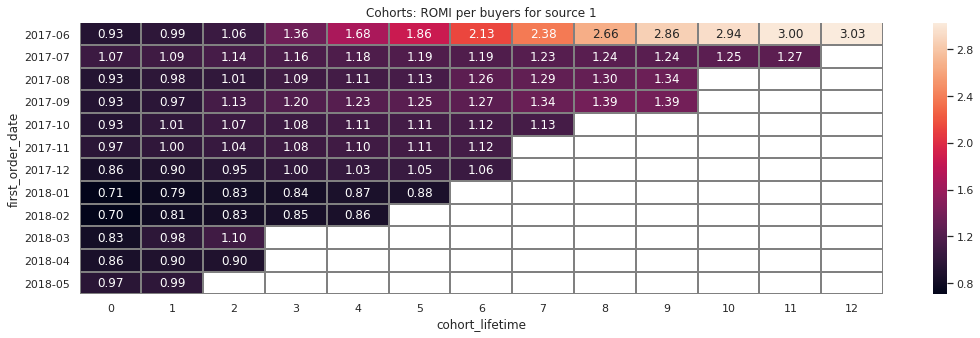

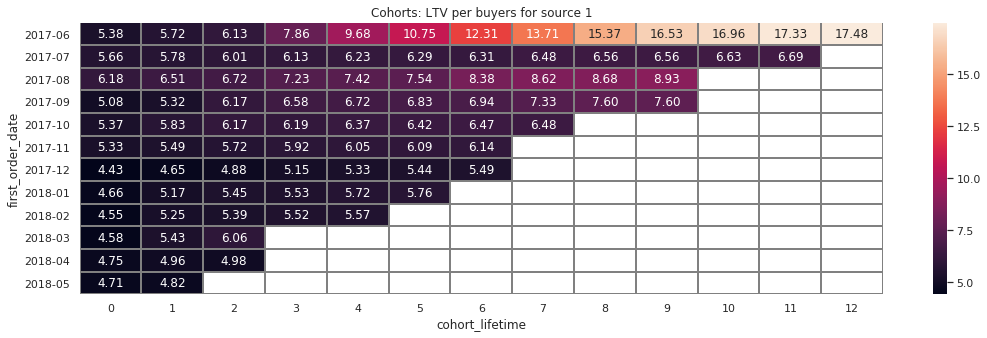

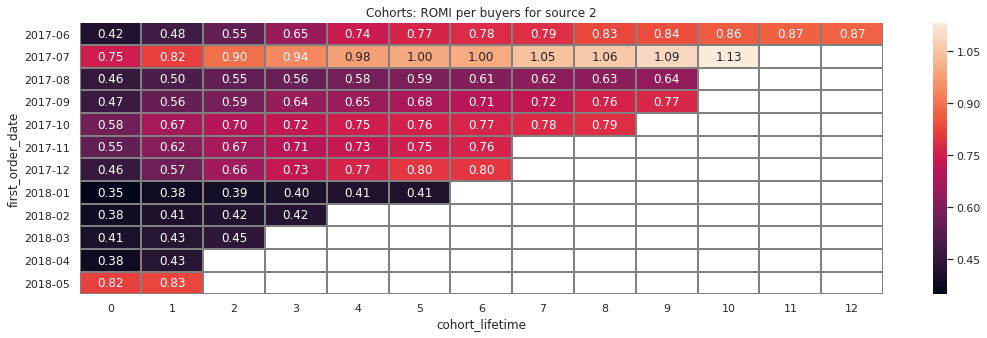

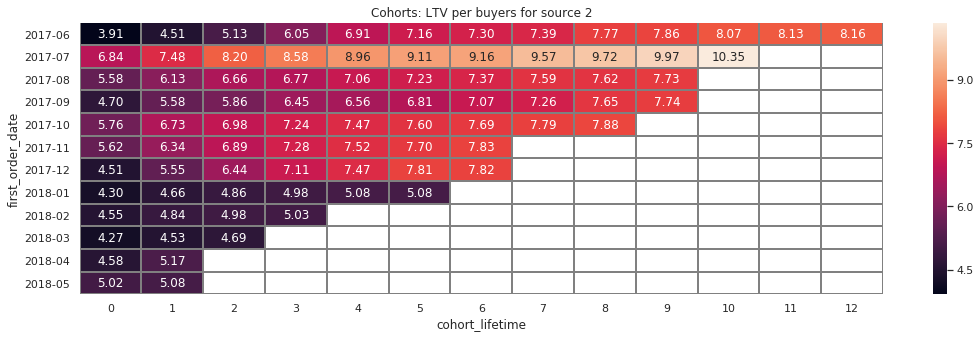

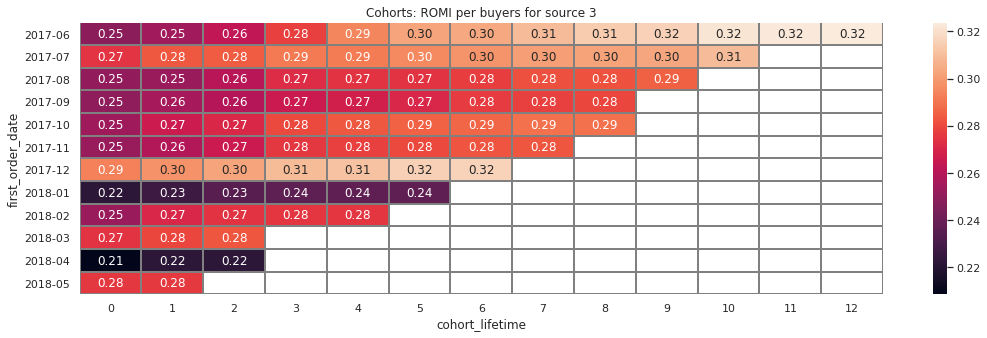

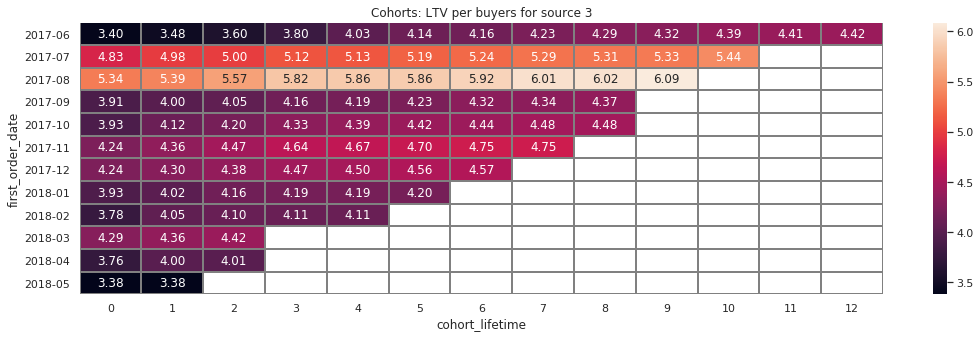

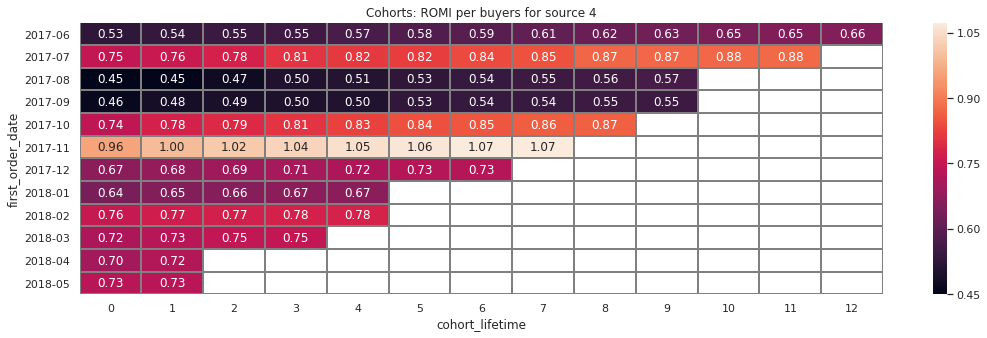

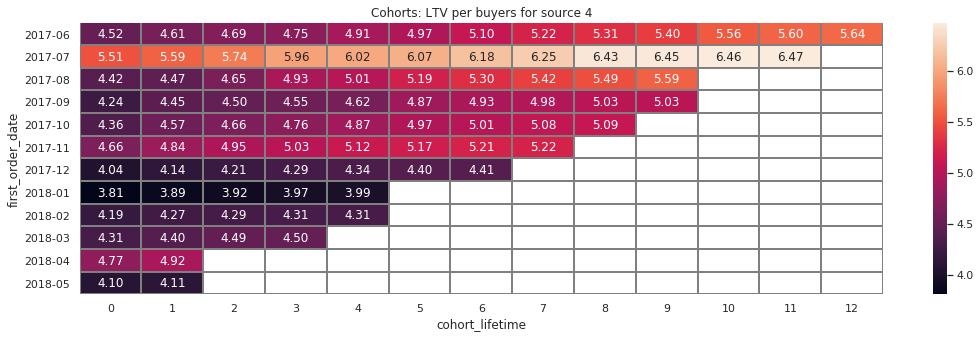

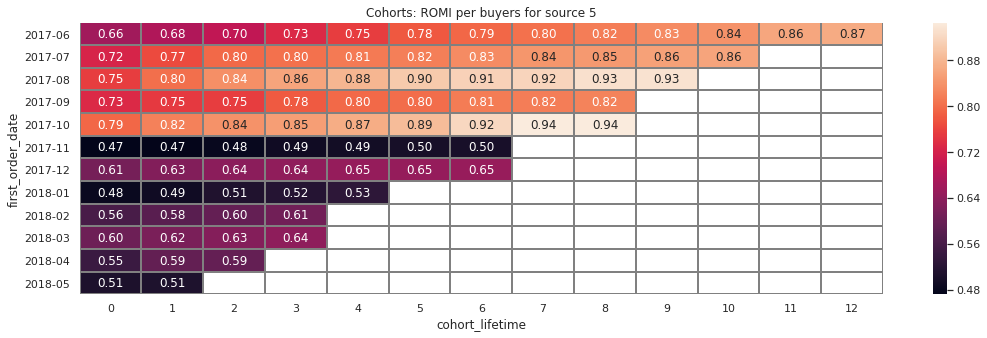

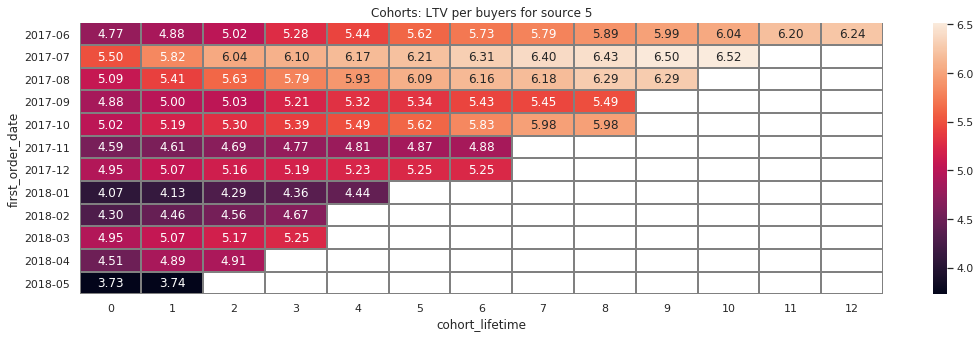

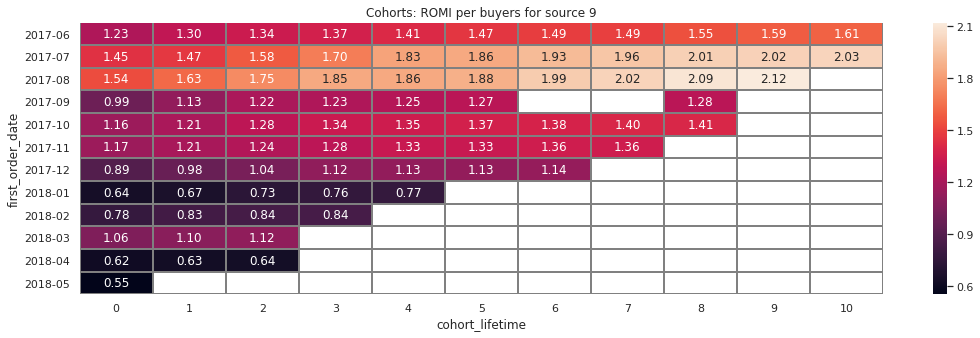

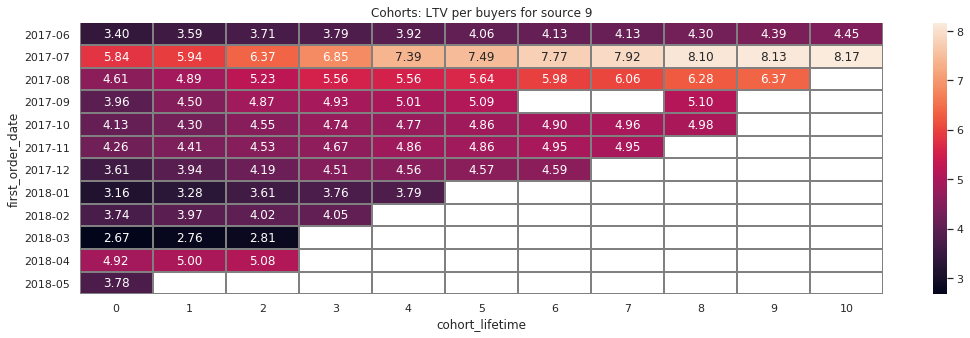

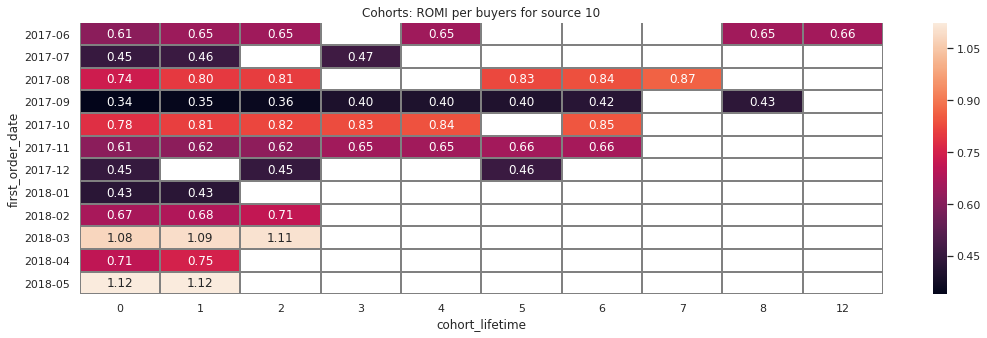

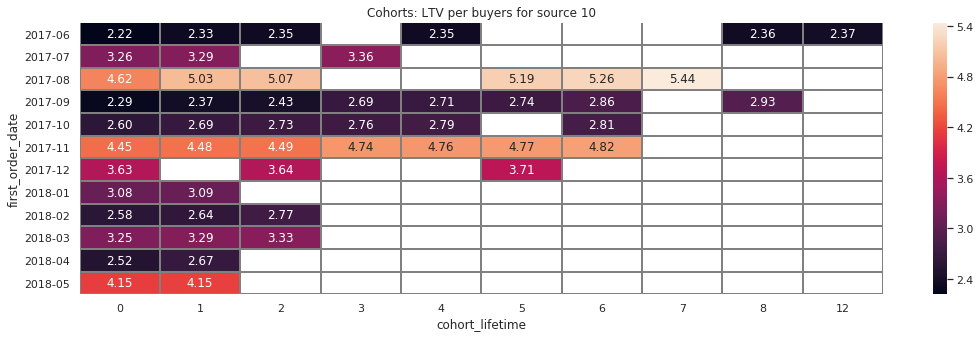

In [134]:
for i in 1, 2, 3, 4, 5, 9, 10:    
    cohort_i = cohort_source.loc[cohort_source['first_source_id'] == i]
    cohort_i_pivot_romi = cohort_i.pivot_table(index = 'first_order_date', columns = 'cohort_lifetime', values = 'romi', aggfunc = 'mean')

    sns.set(style='white')
    plt.figure(figsize=(18, 5))
    plt.title('Cohorts: ROMI per buyers for source {:.0f}'.format(i))
    sns.heatmap(cohort_i_pivot_romi, annot=True, fmt='.2f', linewidths=1, linecolor='grey');
    
    #cohort_i = cohort_source.loc[cohort_source['first_source_id'] == i]
    cohort_i_pivot_lvt = cohort_i.pivot_table(index = 'first_order_date', columns = 'cohort_lifetime', values = 'ltv_cum', aggfunc = 'mean')

    sns.set(style='white')
    plt.figure(figsize=(18, 5))
    plt.title('Cohorts: LTV per buyers for source {:.0f}'.format(i))
    sns.heatmap(cohort_i_pivot_lvt, annot=True, fmt='.2f', linewidths=1, linecolor='grey');


In [135]:
cohort_source.pivot_table(index = 'cohort_lifetime', columns = 'source_id', values = 'romi')

source_id,1,2,3,4,5,9,10
cohort_lifetime,,,,,,,
0,0.891080,0.501680,0.254921,0.674516,0.621324,1.007150,0.665985
1,0.951767,0.558281,0.262186,0.691623,0.642859,1.103919,0.705386
2,1.005178,0.587136,0.265842,0.697220,0.670282,1.161237,0.690691
3,1.073226,0.642171,0.276157,0.710183,0.693091,1.277121,0.587118
4,1.129959,0.701787,0.279387,0.716170,0.722602,1.366188,0.636513
5,1.198345,0.720259,0.282757,0.727615,0.762694,1.473435,0.586513
6,1.308332,0.775565,0.291783,0.736766,0.775201,1.547366,0.692365
7,1.471821,0.792955,0.290435,0.747512,0.864898,1.646728,0.866148
8,1.648593,0.814458,0.293546,0.692104,0.872801,1.666719,0.542931


**ВЫВОД:**

Стоимость привлечения клиентов с помощью первого источника в среднем окупается на второй месяц жизни когорты, а остальных - не окупается и за 12 месяцев. 

**ОБЩИЙ ВЫВОД** 

С среднем ресурс посещает 849 пользователей в день, 5313 - в неделю, 21 452 - в месяц. Тем не менее всего лишь 15% возращаются на сайт в течение недели и 3,96% - в течение месяца. Среднестатистический пользователь заходит 1 раз в день и проводит на сайте 1 минуту, тем не менее. За год среднее кол-во пользователей всего в месяц увеличилось, но количество новых покупателей уменьшилось: пик наблюдался в предновогодние месяцы с 4200 - 4000 новых покупателей в ноябре-декабре соответсвенно со спадом к маю 2018 с 2281 соответвенно, когда как в июне 2016 года было привлечено 2848 пользователей. 

В среднем покупатель проводит около 15 минут на сайте с захода на сайт до совершения первой покупки. За 6 месяцов пользования ресурсом покупатель делает 1,33 покупок и в среднем пользователь приносит 5.05 у.е. валовый прибыли. Пользование ресурсом носит сезонный характер с пиком в осенне-зимний период. Тем не менее тренд падающий: количество новых покупателей ставновится все меньше, они делают одну покупку и уходят с сайта: это может быть связано с сезонностью. 

43% средств тратится на 3 источник для привлечения повых пользователей, 4 и 5 источники на втором и третьем месте (18,5% и 15,7 соответвенно). ROMI одного покупателя по всем источникам -  9.17 у.е. Тем не менее в разрезе по когортам окупается только первый источник трафика на второй месяц жизни когорты, а все остальные - не окупаются и за 12 месяцев жизни.

Рекомендуется пересмотреть маркетинговую политику на акцент удержания клиента и пересмотреть затраты на рекламу, обратив внимание на 1 источник трафика.